In [1]:
import pymc3 as pm
import theano
import theano.tensor as tt

import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')

In [2]:
# df = pd.read_csv('weekly_dmd.csv')
df = pd.read_csv('weekly_dmd_new.csv')
df['date'] = pd.to_datetime(df.date).apply(lambda x: x.date())
df = df.set_index(df.date)
df.index.rename('date_idx', inplace=True)
df.head(2)

,zone_id,date,total_demand_new,total_demand_new_lag1,total_demand_new_lag2,total_demand_new_lag3,total_demand_new_lag-1,total_demand_new_lag-2,total_demand_new_lag-3,smoothed_total_demand,year,total_demand_new_lag4,t4w_total_demand,month,week,day,t4w_total_demand_lag2,szn_factor
date_idx,,,,,,,,,,,,,,,,,,
2017-06-26,1,2017-06-26,1900.84505,NaN,NaN,NaN,2155.673157,2193.532475,2110.494687,NaN,2017,NaN,NaN,6,26,26,NaN,NaN
2017-06-26,410,2017-06-26,0.00000,NaN,NaN,NaN,1.572067,8.671007,13.703718,NaN,2017,NaN,NaN,6,26,26,NaN,NaN


In [159]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

<ipython-input-1205-29803c084a1b>:7: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  fit1 = ExponentialSmoothing(zdf, trend='add', seasonal='mul',
/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:1112: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  warnings.warn(
/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/holtwint

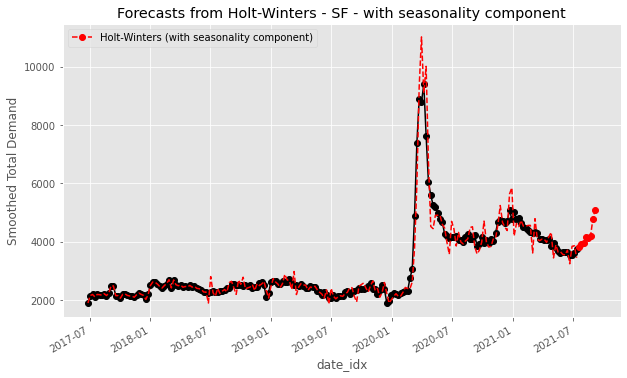

In [1205]:
zdf = df1.sort_values('date').total_demand_new.astype(float)

# zdf = df1.loc[(df1.date < covid_start_idx)
#                 | (df1.date >= covid_start_idx + timedelta(weeks=52))].sort_values('date').total_demand_new.astype(float)


fit1 = ExponentialSmoothing(zdf, trend='add', seasonal='mul',
                            seasonal_periods=52,
#                             damped=True
                            damped=False
                           ).fit(optimized=True, use_boxcox=False)

ax = zdf.plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters - SF - with seasonality component" )
ax.set_ylabel("Smoothed Total Demand")
ax.set_xlabel("Week")
fit1.fittedvalues.plot(ax=ax, style='--', color='red')

fit1.forecast(8).rename('Holt-Winters (with seasonality component)').plot(ax=ax, style='--', marker='o', color='red', legend=True)

plt.show()

In [1206]:
fit1.params

{'smoothing_level': 0.8889285714285714,
 'smoothing_trend': 0.8230820105820106,
 'smoothing_seasonal': 0.1110714285714286,
 'damping_trend': nan,
 'initial_level': 2783.5069797410138,
 'initial_trend': 2.386143219742208,
 'initial_seasons': array([0.68289574, 0.77444503, 0.78804634, 0.75821426, 0.7884416 ,
        0.78535444, 0.7800498 , 0.79779579, 0.77496207, 0.8049305 ,
        0.89501213, 0.8930455 , 0.7739801 , 0.7729854 , 0.74207211,
        0.78991075, 0.79566146, 0.77662844, 0.76978372, 0.76735162,
        0.75392567, 0.78446413, 0.80469954, 0.78912728, 0.77667462,
        0.72745409, 0.78769021, 0.90074226, 0.94180849, 0.93834758,
        0.91596839, 0.88651684, 0.86766494, 0.89792067, 0.92251673,
        0.97017268, 0.86870371, 0.9664977 , 0.90869349, 0.89537723,
        0.90601365, 0.87712368, 0.88626101, 0.88056957, 0.89936271,
        0.87801349, 0.88820917, 0.86324305, 0.8591175 , 0.84884055,
        0.8179303 , 0.81807011]),
 'use_boxcox': False,
 'lamda': None,
 'remove

<AxesSubplot:>

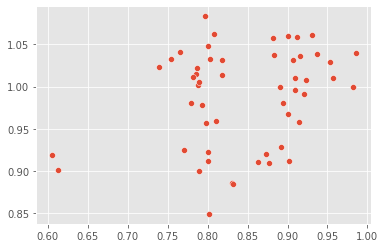

In [165]:
sns.scatterplot(x=fit1.params['initial_seasons'], y=map_estimate['initial_szns'])

/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/results.py:169: FutureWarning: slope is deprecated and will be removed after 0.13
  warnings.warn(


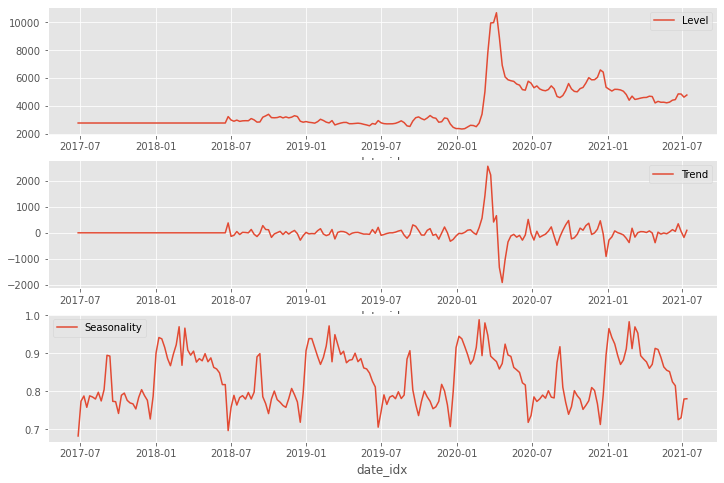

In [1207]:
states1 = pd.DataFrame(np.c_[fit1.level, fit1.slope, fit1.season, fit1.fittedvalues], columns=['level','slope','seasonal', 'fitted_val'], index=zdf.index)

fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(12,8))
states1.level.plot(ax=ax1, label='Level')
states1.slope.plot(ax=ax2, label='Trend')
states1.seasonal.plot(ax=ax3, label='Seasonality')

ax1.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='best')

In [3]:
def fit_hw_model(zdf, initial_lvl_upper):
    szn_len = 52

    with pm.Model() as hw_model:
    #     initial_level = pm.Normal(f'initial_level', mu=3000, sigma=400)
#         initial_level = pm.Uniform(f'initial_level', lower=0, upper=5000)
        initial_level = pm.Uniform(f'initial_level', lower=0, upper=initial_lvl_upper)
        smoothing_level = pm.Uniform('smoothing_level', lower=0, upper=1)
#         smoothing_level = pm.Normal('smoothing_level', mu=0.5, sigma=0.5)

    #     initial_trend = pm.Normal(f'initial_trend', mu=0, sigma=100)
#         initial_trend = pm.Uniform(f'initial_trend', lower=-1000, upper=1000)
        initial_trend = pm.Uniform(f'initial_trend', lower=-initial_lvl_upper/2, upper=initial_lvl_upper/2)
        smoothing_trend = pm.Uniform('smoothing_trend', lower=0, upper=1)
    #     smoothing_trend = pm.Normal('smoothing_trend', mu=0.5, sigma=0.5)

        if len(zdf) < szn_len*2.5:
#         if len(zdf) < szn_len*2:
#             initial_szns = pm.Deterministic('initial_szns', 1.0, dims=(szn_len))
            initial_szns = tt.as_tensor_variable([1.0 for i in range(52)])
            smoothing_season = 0.0
#             smoothing_season = pm.Deterministic('smoothing_season', 1.0)
        else:
            initial_szns = pm.Normal('initial_szns', mu=1.0, sigma=0.2, shape=(szn_len))
        #     initial_szns = pm.Uniform('initial_szns', lower=0.7, upper=1.3, shape=(szn_len))
        #     smoothing_season = pm.Uniform('smoothing_season', lower=0, upper=1)
        #     smoothing_season = pm.Uniform('smoothing_season', lower=0, upper=1)
        #     smoothing_season = pm.Uniform('smoothing_season', lower=0, upper=1-smoothing_level)
            smoothing_season = pm.TruncatedNormal('smoothing_season', mu=0.2, sigma=0.5, lower=0, upper=0.8)
        #     smoothing_season = pm.Normal('smoothing_season', mu=0.5, sigma=0.5)

        ys = tt.as_tensor_variable(zdf['y_obs'])
        is_covid_start = tt.as_tensor_variable(zdf['covid_start_m1'])
    #     covid_level_change = pm.Normal('covid_level_change', mu=15000, sigma=2000)
        covid_level_change = pm.Uniform('covid_level_change', lower=0, upper=5000)
#         covid_level_change = pm.Normal('covid_level_change', mu=2000, sigma=1000)
    #     covid_level_change2 = pm.Normal('covid_level_change2', mu=20000, sigma=2000)
        covid_level_change2 = pm.Uniform('covid_level_change2', lower=0, upper=5000)
    #     covid_level_change2 = pm.Normal('covid_level_change2', mu=covid_level_change, sigma=1000)
    #     covid_level_change2 = pm.Normal('covid_level_change2', mu=covid_level_change, sigma=1000)

        def hw_component_wise(y, covid_start, prior_level, prior_trend, szn_m52):
            updated_szn = smoothing_season * y / (prior_level + prior_trend) + (1 - smoothing_season) * szn_m52


            next_level = smoothing_level * (y/szn_m52) + (1 - smoothing_level)*(prior_level + prior_trend) + covid_start*covid_level_change
            next_trend = smoothing_trend * (next_level - prior_level) + (1 - smoothing_trend)*prior_trend - covid_start*smoothing_trend*covid_level_change2


            return next_level, next_trend, updated_szn

        outputs, updates = theano.scan(hw_component_wise,
               sequences = [
                   ys[1:],
#                    ys[szn_len:],
                   is_covid_start[1:]
#                    is_covid_start[szn_len:]
        #            post_covid[szn_len:]
               ],
               outputs_info = [
                   dict(initial = initial_level, taps=None),
                   dict(initial = initial_trend, taps=None),
                   dict(initial = initial_szns, taps=[-szn_len])
               ], 
        #            non_sequences = 
               )


        levels = outputs[0]
        trends = outputs[1]
        seasons = outputs[2]


        levels_f = pm.math.concatenate([initial_level.reshape(1,1), levels[:-1]])
        trends_f = pm.math.concatenate([initial_trend.reshape(1,1), trends[:-1]])
        seasons_f = pm.math.concatenate([initial_szns, seasons[:-szn_len]])

        levels_and_trends = pm.math.stack([levels_f, trends_f])
        level_plus_trend = levels_and_trends.sum(axis=0)

        level_plus_trend_and_seasons = pm.math.stack([level_plus_trend, seasons_f])
        y_hats = level_plus_trend_and_seasons.prod(axis=0)

        sig = pm.HalfCauchy('sigma', beta=10)
#         y_like = pm.Normal('y_like', mu=y_hats, sigma=sig, observed=zdf.iloc[szn_len-1:-1, :]['y_obs_lag-1'])
        y_like = pm.Normal('y_like', mu=y_hats, sigma=sig, observed=zdf.iloc[:-1, :]['y_obs_lag-1'])
        
    map_estimate = pm.find_MAP(model=hw_model)
    
    return map_estimate, ys, is_covid_start

In [4]:
def predict(map_estimate, ys, is_covid_start, horizon):
    
    if 'initial_szns' in map_estimate:
        szn_estimates = tt.as_tensor_variable(map_estimate['initial_szns'])
        szn_smoother = map_estimate['smoothing_season']
    else:
        szn_estimates = tt.as_tensor_variable([1.0 for i in range(52)])
        szn_smoother = 0.0

    def hw_component_wise_final(y, covid_start, prior_level, prior_trend, szn_m52):
            updated_szn = szn_smoother * y / (prior_level + prior_trend) + (1 - szn_smoother) * szn_m52
#             updated_szn = map_estimate['smoothing_season'] * y / (prior_level + prior_trend) + (1 - map_estimate['smoothing_season']) * szn_m52


            next_level = map_estimate['smoothing_level'] * (y/szn_m52) + (1 - map_estimate['smoothing_level'])*(prior_level + prior_trend) + covid_start*map_estimate['covid_level_change']
            next_trend = map_estimate['smoothing_trend'] * (next_level - prior_level) + (1 - map_estimate['smoothing_trend'])*prior_trend - covid_start*map_estimate['smoothing_trend']*map_estimate['covid_level_change2']


            return next_level, next_trend, updated_szn

    outputs, updates = theano.scan(hw_component_wise_final,
               sequences = [
#                    ys[szn_len:],
                   ys[1:],
#                    is_covid_start[szn_len:]
                   is_covid_start[1:]
        #            post_covid[szn_len:]
               ],
               outputs_info = [
                   dict(initial = map_estimate['initial_level'], taps=None),
                   dict(initial = map_estimate['initial_trend'], taps=None),
                   dict(initial = szn_estimates, taps=[-szn_len])
#                    dict(initial = tt.as_tensor_variable(map_estimate['initial_szns']), taps=[-szn_len])
               ], 
        #            non_sequences = 
               )
    
    levels = outputs[0]
    trends = outputs[1]
    seasons = outputs[2]

    levels_f = pm.math.concatenate([map_estimate['initial_level'].reshape(1), levels[:-1]])
    trends_f = pm.math.concatenate([map_estimate['initial_trend'].reshape(1), trends[:-1]])
#     seasons_f = pm.math.concatenate([map_estimate['initial_szns'], seasons[:-szn_len]])
    seasons_f = pm.math.concatenate([szn_estimates, seasons[:-szn_len]])

    levels_and_trends = pm.math.stack([levels_f, trends_f])
    level_plus_trend = levels_and_trends.sum(axis=0)

    level_plus_trend_and_seasons = pm.math.stack([level_plus_trend, seasons_f])
    y_hats = level_plus_trend_and_seasons.prod(axis=0)
    
    corresponding_szn_idx = (horizon - szn_len) - 1
#     szn_estimate = seasons_f.get_test_value()[corresponding_szn_idx]
    szn_estimate = seasons.get_test_value()[corresponding_szn_idx]

#     pred = (levels_f.get_test_value()[-1] + horizon*trends_f.get_test_value()[-1])*szn_estimate
    pred = (levels.get_test_value()[-1] + horizon*trends.get_test_value()[-1])*szn_estimate
#     return pred, levels, trends, seasons, corresponding_szn_idx, szn_estimate, y_hats
    return pred, levels_f, trends_f, seasons_f, seasons, corresponding_szn_idx, szn_estimate, y_hats

In [5]:
F_DATE = date(2021,6,7)
# test_f_dates = [F_DATE - timedelta(weeks=i) for i in range(110)]
test_f_dates = [F_DATE - timedelta(weeks=i) for i in range(80)]

In [6]:
covid_start_idx = date(2020,2,17)

df_prep = df.loc[(df.date < covid_start_idx)
                | (df.date >= covid_start_idx + timedelta(weeks=52))].sort_values('date')

df_prep['y_obs'] = df_prep.total_demand_new
# df_prep['y_obs'] = df_prep.smoothed_total_demand
df_prep['covid_start_m1'] = df_prep.date.apply(lambda x: 1.0 if x == covid_start_idx - timedelta(weeks=1) else 0)

In [338]:
len(test_f_dates)

80

In [10]:
test_dates2 = test_f_dates[:10:3] + test_f_dates[-7::3]
test_dates2

[datetime.date(2021, 6, 7),
 datetime.date(2021, 5, 17),
 datetime.date(2021, 4, 26),
 datetime.date(2021, 4, 5),
 datetime.date(2020, 1, 13),
 datetime.date(2019, 12, 23),
 datetime.date(2019, 12, 2)]

In [7]:
recent_dmd_by_zone = df.loc[df.date >= date(2021,3,1)].groupby('zone_id').total_demand_new.sum().reset_index()
recent_dmd_by_zone.sort_values('total_demand_new', ascending=False).head(2)

,zone_id,total_demand_new
403,785,190316.615898
437,942,166977.068545


In [8]:
zz = recent_dmd_by_zone.sort_values('total_demand_new', ascending=False).head(20).zone_id.tolist()
zz2 = recent_dmd_by_zone.sort_values('total_demand_new', ascending=False).iloc[20:30].zone_id.tolist()
zz3 = recent_dmd_by_zone.sort_values('total_demand_new', ascending=False).iloc[30:50].zone_id.tolist()
zz4 = recent_dmd_by_zone.sort_values('total_demand_new', ascending=False).iloc[50:70].zone_id.tolist()
zz5 = recent_dmd_by_zone.sort_values('total_demand_new', ascending=False).iloc[70:90].zone_id.tolist()

zz_top90 = recent_dmd_by_zone.sort_values('total_demand_new', ascending=False).iloc[:90].zone_id.tolist()

In [1040]:
recent_dmd_by_zone.sort_values('total_demand_new', ascending=False).iloc[:90].total_demand_new.sum()

4523816.334892994

In [1046]:
df_prep.zone_id.nunique(), HORIZON

(475, 2)

In [ ]:
# res4_1p is zz5 + zz

In [968]:
test_dates2

[datetime.date(2021, 6, 7),
 datetime.date(2021, 5, 17),
 datetime.date(2021, 4, 26),
 datetime.date(2021, 4, 5),
 datetime.date(2020, 1, 13),
 datetime.date(2019, 12, 23),
 datetime.date(2019, 12, 2)]

In [12]:
HORIZON

NameError: name 'HORIZON' is not defined

In [1168]:
df_prep.date.max() - timedelta(weeks=2)

datetime.date(2021, 6, 28)

In [1235]:
date(2021,7,12) - timedelta(weeks=2)

datetime.date(2021, 6, 28)

In [14]:
### walk-forward validation
HORIZON = 2 # (ie 15-21 days out) compare to TARGET_lag3
szn_len = 52

idx_outer = 1
pred_for_dates, zone_ids, preds, smoothing_levels, smoothing_trends, smoothing_seasons = [], [], [], [], [], []
# for f_date in test_dates2[1:2]:
# for f_date in test_dates2[0:1]:
# for f_date in test_dates2:
# for f_date in [date(2020,1,27)-timedelta(weeks=HORIZON)]:
# for f_date in test_dates2[0:1]:
# for f_date in [date(2021,6,28), date(2021,4,26)]:
# for f_date in [date(2021,6,28), date(2021,7,19)]:
# for f_date in [date(2021,4,26)]:
# for f_date in [date(2021,7,19)]:
for f_date in [date(2021,7,26)]:
# for f_date in [date(2021,6,28)]:
# for f_date in [date(2019,12,2)]:
# for f_date in test_f_dates[:5]:
    print(f'iter {idx_outer}/{len(test_dates2)}')
    idx_outer += 1
    
    idx_inner = 1
#     for z_id in zz4[1:]:
#     for z_id in zz5 + zz:
#     for z_id in zz4:
#     for z_id in zz3:
#     for z_id in zz2:
#     for z_id in zz:
    for z_id in zz_top90:
#     for z_id in [972]:
#     for z_id in [874]:
#     for z_id in df_prep.zone_id.unique():
#     for z_id in [1001, 943, 787]:
#     for z_id in [1435]:
#     for z_id in [1]:
#     for z_id in [1,973,13]:
#     for z_id in [1,973,13,785,979,1001,972,942,18,27]:

        print(f'inner iter {idx_inner}')
        
#         third_week = df_prep.loc[df_prep.zone_id == z_id].date.unique()[2]
        zdf = df_prep.loc[(df_prep.zone_id == z_id)
                            & (df_prep.date < f_date)
#                             & (df_prep.date > third_week)
                            & (df_prep['y_obs'] > 0)
                           ]
    
        third_week = zdf.date.unique()[2]
        zdf = zdf.loc[zdf.date > third_week]
        
        
        pad_df = pd.DataFrame(columns = zdf.columns)
        pad_df.loc[0, 'zone_id'] = z_id
        zdf = pd.concat([pad_df, zdf])
        
        zdf['y_obs_lag-1'] = zdf.y_obs.shift(-1)
        initial_lvl_upper = zdf.head()['y_obs_lag-1'].max()
        
        
#         if len(zdf) < 104:
#             break
            
        map_estimate, ys, is_covid_start = fit_hw_model(zdf, initial_lvl_upper)
        pred, levels_f, trends_f, seasons_f, seasons, corresponding_szn_idx, szn_estimate, yhats = predict(map_estimate, ys, is_covid_start, HORIZON+1)
        
        pred_for_date = f_date + timedelta(weeks=HORIZON)
        
        pred_for_dates.append(pred_for_date)
        zone_ids.append(z_id)
        preds.append(pred)
        smoothing_levels.append(map_estimate['smoothing_level'])
        smoothing_trends.append(map_estimate['smoothing_trend'])
        if 'smoothing_season' in map_estimate:
            smoothing_seasons.append(map_estimate['smoothing_season'])
        else:
            smoothing_seasons.append(0.0)
        idx_inner += 1
        
res1 = pd.DataFrame({'pred_for_date': pred_for_dates,
                        'zone_id': zone_ids,
                        'pred': preds,
                        'smoothing_level': smoothing_levels,
                        'smoothing_trend': smoothing_trends,
                        'smoothing_season': smoothing_seasons})

res1.pred_for_date = pd.to_datetime(res1.pred_for_date)

iter 1/7
inner iter 1


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 2


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 3


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 4


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 5


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 6


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 7


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 8


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 9


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 10


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 11


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 12


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 13


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 14


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 15


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 16


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 17


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 18


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 19


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 20


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 21


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 


inner iter 22


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 23


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 24


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 25


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 26


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 27


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 28


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 29


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 30


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 31


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 32


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 33


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 34


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 35


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 36


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 37


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 38


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 39


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 


inner iter 40


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 


inner iter 41


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 


inner iter 42


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 43


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 44


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 45


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 46


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 47


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 48


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 49


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 50


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 


inner iter 51


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 52


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 53


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 54


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 55


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 56


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 57


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 58


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 59


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 60


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 61


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 62


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 63


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 64


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 65


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 66


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 67


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 68


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 69


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 70


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 71


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 72


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 73


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 74


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 75


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 76


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 77


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 78


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 79


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 80


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 81


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 82


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 83


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 84


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 85


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 86


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 87


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 88


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 89


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 



inner iter 90


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 


In [17]:
res1.to_csv('./demand_fcast_fdate_07_26_21.csv', index=None)
# res1.to_csv('./demand_fcast_fdate_06_28_21.csv', index=None)

# res1.to_csv('./demand_fcast_fdate_07_19_21.csv', index=None)

In [15]:
res1.shape

(90, 6)

In [1244]:
res1.zone_id.unique()

array([ 785,  942,  972,  861,  973,  943,  975,  981, 1002,  983,  974,
       1001,  839,  714,    1,  783,  989,  787,   79,  945,  946,  980,
        979,   27,  131,  786,  183,   33,   87,  392,   43,   16,  982,
        713,  988,  262,  840,  144,  709,  181,  440,  204,  225,  185,
        245,  104,  182,  439,  103,  169,   50,  186,   37,  620,  441,
         76,  184,   32,  477,  530,  616,  617,  357,  167,  437, 1029,
         38,  166,  428,  307,  853,  541,  438,   18,  266,  692,  272,
         90,  495,  475,  178,  348,  273,  521,  161,  694,  707,  190,
        452,  759])

In [1215]:
map_estimate

{'initial_level_interval__': array(19.22669955),
 'smoothing_level_interval__': array(0.86590661),
 'initial_trend_interval__': array(-0.00190908),
 'smoothing_trend_interval__': array(-10.34770102),
 'initial_szns': array([0.94747692, 0.95936983, 0.96585927, 0.96074868, 0.99006776,
        0.99545837, 0.9918051 , 1.05585219, 1.06221651, 1.00981389,
        1.02439174, 1.005526  , 1.01692596, 1.03053691, 1.02256756,
        1.03978467, 0.9968859 , 0.99539788, 0.98361543, 1.03261202,
        1.05561453, 1.01316826, 0.86473329, 0.92288674, 1.04986981,
        1.08263334, 1.07227068, 1.04538902, 1.04490835, 1.05762734,
        1.06895958, 1.08783109, 1.10013576, 1.0584884 , 1.08144999,
        1.06463847, 1.03001456, 1.03930133, 1.02213132, 1.01981277,
        1.02485211, 1.00357644, 1.00870945, 0.99280213, 0.96286708,
        0.94869795, 0.94401896, 0.94470427, 0.93725437, 0.91201299,
        0.91655781, 0.93776362]),
 'smoothing_season_interval__': array(-15.54619577),
 'covid_level_cha

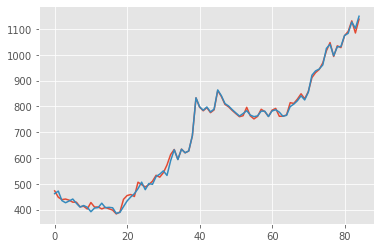

In [717]:
zdf.iloc[1:].reset_index().y_obs.plot()
plt.plot(yhats.get_test_value())

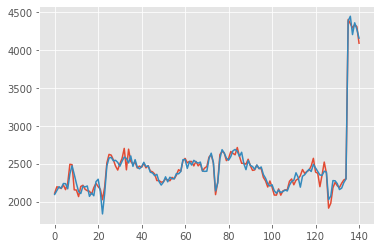

In [792]:
# SF
zdf.iloc[1:].reset_index().y_obs.plot()
plt.plot(yhats.get_test_value())

In [795]:
all_season_estimates = map_estimate['initial_szns'].tolist() + seasons.get_test_value().tolist()

corresponding_dates = zdf.iloc[1:].date.tolist()
for i in range(szn_len):
    corresponding_dates += [corresponding_dates[-1] + timedelta(weeks=1)]

szn_estimates_w_dates = pd.DataFrame(list(zip(all_season_estimates, corresponding_dates)), columns=['szn_estimate', 'date'])

szn_estimates_w_dates = szn_estimates_w_dates.set_index(szn_estimates_w_dates.date)

In [796]:
szn_estimates_w_dates.loc[szn_estimates_w_dates.date >= f_date].head()

,szn_estimate,date
date,,
2021-03-29,1.047756,2021-03-29
2021-04-05,1.016604,2021-04-05
2021-04-12,1.011627,2021-04-12
2021-04-19,1.012378,2021-04-19
2021-04-26,1.039037,2021-04-26


In [797]:
szn_estimates_w_dates['szn_estimate_lag1'] = szn_estimates_w_dates.szn_estimate.shift(1)
szn_estimates_w_dates['szn_change'] = szn_estimates_w_dates.szn_estimate - szn_estimates_w_dates.szn_estimate_lag1
szn_estimates_w_dates['szn_change_abs'] = szn_estimates_w_dates['szn_change'].abs()

In [784]:
szn_estimates_w_dates.loc[szn_estimates_w_dates.szn_change_abs > .1]

,szn_estimate,date,szn_estimate_lag1,szn_change,szn_change_abs
date,,,,,
2018-05-21,1.201213,2018-05-21,1.005496,0.195716,0.195716
2018-05-28,0.911555,2018-05-28,1.201213,-0.289658,0.289658
2018-06-18,1.000978,2018-06-18,0.869514,0.131464,0.131464
2018-06-25,1.105119,2018-06-25,1.000978,0.104141,0.104141
2018-07-09,0.894454,2018-07-09,1.099729,-0.205274,0.205274
...,...,...,...,...,...
2022-02-14,0.346524,2022-02-14,0.532629,-0.186105,0.186105
2022-02-28,0.613922,2022-02-28,0.431329,0.182593,0.182593
2022-03-07,1.074131,2022-03-07,0.613922,0.460209,0.460209


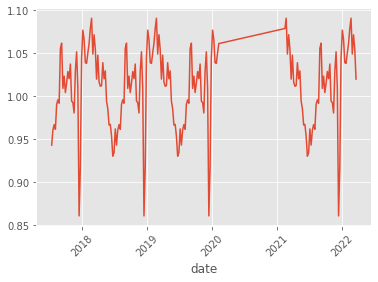

In [798]:
ax = szn_estimates_w_dates.szn_estimate.plot()
ax.xaxis.set_tick_params(rotation=45)

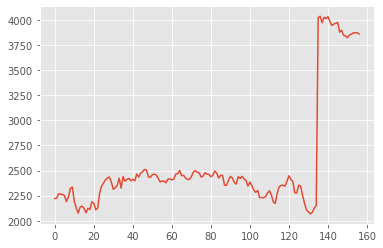

In [1184]:
plt.plot(levels_f.get_test_value())

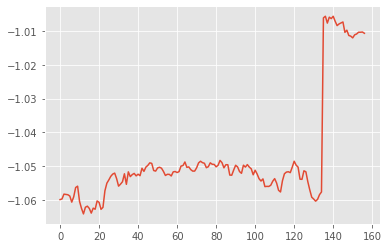

In [1186]:
plt.plot(trends_f.get_test_value())

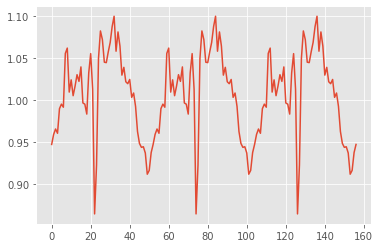

In [1187]:
plt.plot(seasons_f.get_test_value())

In [1198]:
ss = pd.DataFrame(zip(zdf.iloc[1:].date, seasons_f.get_test_value()), columns=['date', 'season_effect'])
ss = ss.set_index(ss.date)

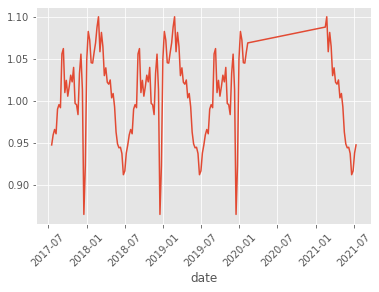

In [1200]:
ax = ss.season_effect.plot()
ax.xaxis.set_tick_params(rotation=45)

In [1246]:
res1['pred_for_date'] = res1.pred_for_date.apply(lambda x: x.date())

f1 = res1.merge(df, left_on=['zone_id', 'pred_for_date'], right_on=['zone_id', 'date'])
f1 = f1.set_index(f1.pred_for_date)
f1.shape

(90, 23)

In [413]:
f1['error_new'] = f1.pred - f1.total_demand_new
f1['pct_error_new'] = f1.error_new / f1.total_demand_new
f1['abs_error_new'] = f1.error_new.abs()
f1['abs_pct_error_new'] = f1.pct_error_new.abs()

f1['error_old'] = f1.total_demand_new_lag3 - f1.total_demand_new
f1['pct_error_old'] = f1.error_old / f1.total_demand_new
f1['abs_error_old'] = f1.error_old.abs()
f1['abs_pct_error_old'] = f1.pct_error_old.abs()

In [1135]:
all_backtests.loc[all_backtests.pred_for_date.isin(f4_26_v3.pred_for_date)][['abs_pct_error_new', 'abs_pct_error_old']].describe()

,abs_pct_error_new,abs_pct_error_old
count,90.000000,90.000000
mean,0.050748,0.059406
std,0.046843,0.035605
min,0.002699,0.003052
25%,0.019745,0.031113
50%,0.037734,0.056606
75%,0.068492,0.083699
max,0.286628,0.178745


In [1015]:
all_backtests.pred_for_date.unique()

array([datetime.date(2021, 6, 21), datetime.date(2021, 5, 31),
       datetime.date(2021, 5, 10), datetime.date(2021, 4, 19),
       datetime.date(2020, 1, 27), datetime.date(2020, 1, 6),
       datetime.date(2019, 12, 16)], dtype=object)

In [943]:
### combine results from various backtests

# all_backtests = pd.concat([f4_1p, f4_4, f4_3, f4_2])
# all_backtests.to_csv('./all_backtests_7_13.csv', index=None)

In [956]:
all_backtests['error_new'] = all_backtests.pred - all_backtests.total_demand_new
all_backtests['pct_error_new'] = all_backtests.error_new / all_backtests.total_demand_new
all_backtests['abs_error_new'] = all_backtests.error_new.abs()
all_backtests['abs_pct_error_new'] = all_backtests.pct_error_new.abs()

all_backtests['error_old'] = all_backtests.total_demand_new_lag3 - all_backtests.total_demand_new
all_backtests['pct_error_old'] = all_backtests.error_old / all_backtests.total_demand_new
all_backtests['abs_error_old'] = all_backtests.error_old.abs()
all_backtests['abs_pct_error_old'] = all_backtests.pct_error_old.abs()

In [1020]:
all_backtests.pred_for_date.max()

datetime.date(2021, 6, 21)

In [1211]:
all_backtests['abs_pct_error_new'] = 100*all_backtests['abs_pct_error_new']

In [1212]:
all_backtests[['abs_pct_error_new', 'naive_abs_pct_error']].describe()

,abs_pct_error_new,naive_abs_pct_error
count,630.000000,630.000000
mean,5.519759,6.129870
std,5.192718,5.146579
min,0.016198,0.018135
25%,1.900322,2.195949
50%,3.808896,5.137380
75%,7.579060,8.283358
max,30.299919,30.479991


In [950]:
### clip forecasts

max_pct_change = .15
all_backtests['max_pred'] = (1+max_pct_change) * all_backtests.total_demand_new_lag3
all_backtests['min_pred'] = (1-max_pct_change) * all_backtests.total_demand_new_lag3

all_backtests['pred2_prep'] = np.maximum(all_backtests.min_pred, all_backtests.pred)
all_backtests['pred2'] = np.minimum(all_backtests.max_pred, all_backtests.pred2_prep)

all_backtests['error_new2'] = all_backtests.pred2 - all_backtests.total_demand_new
all_backtests['pct_error_new2'] = all_backtests.error_new2 / all_backtests.total_demand_new
all_backtests['abs_error_new2'] = all_backtests.error_new2.abs()
all_backtests['abs_pct_error_new2'] = all_backtests.pct_error_new2.abs()

In [951]:
all_backtests[['abs_pct_error_new', 'abs_pct_error_new2', 'abs_pct_error_old']].describe()

,abs_pct_error_new,abs_pct_error_new2,abs_pct_error_old
count,560.000000,630.000000,560.000000
mean,0.054498,0.054840,0.051588
std,0.051463,0.051206,0.044787
min,0.000162,0.000162,0.000138
25%,0.018577,0.018928,0.019886
50%,0.037787,0.038132,0.041644
75%,0.075428,0.075687,0.071096
max,0.302999,0.302999,0.310027


In [948]:
all_backtests.zone_id.unique()

array([  18,  307,  438,  266,   90,  541,  272,  692,  475,  348,  273,
        178,  495,  694,  190,  707,  161,  521,  452,  489,  785,  942,
        972,  861,  973,  943,  975,  981,  974, 1002,  983, 1001,  839,
        714,    1,  783,  989,  787,   79,  945,  169,   37,  186,   76,
        620,  441,   32,  184,  477,  357,  530,  616,  167,  617,  437,
         38,  166, 1029,  428,  853,   43,   16,  982,  713,  988,  262,
        840,  144,  709,  181,  204,  440,  225,  245,  185,  104,  182,
        103,  439,   50,  946,  980,   27,  979,  183,  786,  131,   33,
        392,   87])

In [949]:
all_backtests.zone_id.nunique()

90

In [427]:
### zone performance

zp = f1.groupby('zone_id').agg({'abs_pct_error_new': ['mean', 'median'], 'abs_pct_error_old': ['mean', 'median']})
zp.columns = ['_'.join(col).strip() for col in zp.columns.values]

zp['mean_diff'] = zp.abs_pct_error_new_mean - zp.abs_pct_error_old_mean
zp['median_diff'] = zp.abs_pct_error_new_median - zp.abs_pct_error_old_median

zp.reset_index(inplace=True)

zp.head(2)

,zone_id,abs_pct_error_new_mean,abs_pct_error_new_median,abs_pct_error_old_mean,abs_pct_error_old_median,mean_diff,median_diff
0,1,0.065522,0.028191,0.075289,0.042111,-0.009767,-0.013920
1,79,0.035838,0.040102,0.042291,0.035288,-0.006454,0.004814


In [1075]:
zp.sort_values('median_diff').head()

,zone_id,abs_pct_error_new_mean,abs_pct_error_new_median,abs_pct_error_old_mean,abs_pct_error_old_median,mean_diff,median_diff
4,32,0.079717,0.079717,0.185021,0.185021,-0.105303,-0.105303
3,27,0.066588,0.066588,0.154937,0.154937,-0.088348,-0.088348
47,452,0.014834,0.014834,0.099895,0.099895,-0.085061,-0.085061
1,16,0.017256,0.017256,0.098427,0.098427,-0.081171,-0.081171
86,989,0.006577,0.006577,0.082141,0.082141,-0.075564,-0.075564


In [ ]:
# top 3

In [ ]:
# 983 looking good, just extrapolating too much trend in recent period
# maybe need a dampening parameter

In [1096]:
f4_26.loc[f4_26.zone_id.isin(zp.sort_values('median_diff').tail().zone_id)][['zone_id', 'smoothing_level', 'smoothing_trend', 'smoothing_season']]

,zone_id,smoothing_level,smoothing_trend,smoothing_season
pred_for_date,,,,
2021-05-10,946,0.072141,0.998854,0.000005
2021-05-10,18,0.721577,0.010528,0.000047
2021-05-10,266,0.299178,0.071430,0.000027
2021-05-10,692,0.839284,0.075799,0.000234
2021-05-10,521,0.407648,0.065527,0.000083


In [1104]:
f4_26.loc[f4_26.zone_id == 692][['date', 'total_demand_new', 'pred', 'total_demand_new_lag3']]

,date,total_demand_new,pred,total_demand_new_lag3
pred_for_date,,,,
2021-05-10,2021-05-10,1464.051703,1872.358455,1642.712088


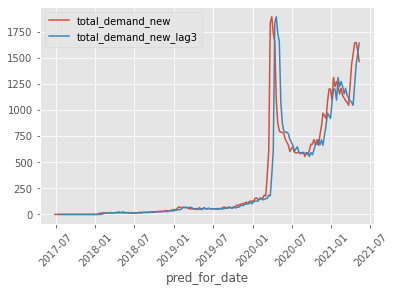

In [1105]:
ax = df.loc[(df.zone_id == 692)&(df.date <= f_date + timedelta(weeks=HORIZON))][['total_demand_new', 'total_demand_new_lag3']].plot()

f4_26.loc[f4_26.zone_id == 692].pred.plot(ax=ax)

ax.xaxis.set_tick_params(rotation=45)

<AxesSubplot:xlabel='date_idx'>

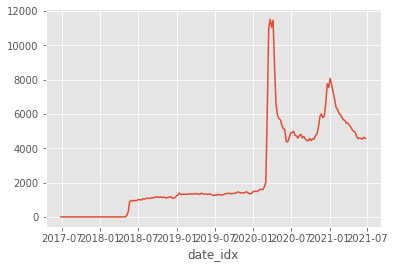

In [431]:
df.loc[df.zone_id == 983].total_demand_new.plot()

<AxesSubplot:xlabel='date_idx'>

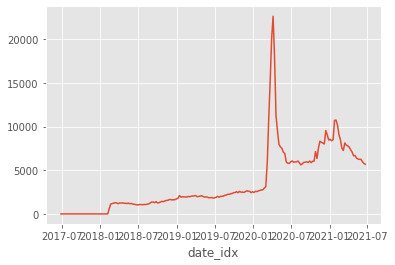

In [433]:
df.loc[df.zone_id == 861].total_demand_new.plot()

<AxesSubplot:xlabel='date_idx'>

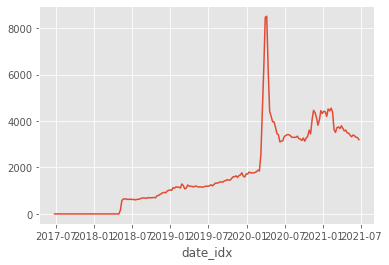

In [434]:
df.loc[df.zone_id == 989].total_demand_new.plot()

In [ ]:
# btm 3 (1001, 943, 787)

In [736]:
f4.loc[f4.zone_id == 974][['date', 'total_demand_new', 'pred', 'total_demand_new_lag3']]

,date,total_demand_new,pred,total_demand_new_lag3
pred_for_date,,,,
2021-06-21,2021-06-21,4635.691899,4425.085032,4783.576204
2021-05-31,2021-05-31,4783.576204,4487.976940,4901.835912
2021-05-10,2021-05-10,4901.835912,5107.128759,5314.633336
2021-04-19,2021-04-19,5314.633336,5741.627466,5328.496810
2020-01-27,2020-01-27,2734.623225,2729.935405,2688.233743
2020-01-06,2020-01-06,2688.233743,2859.332854,2290.397509
2019-12-16,2019-12-16,2290.397509,2091.314580,2571.524910


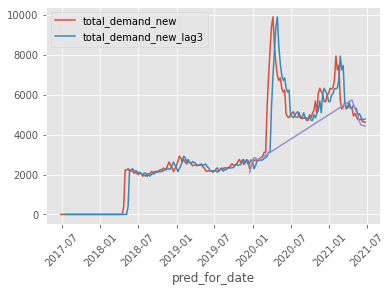

In [732]:
ax = df.loc[df.zone_id == 974][['total_demand_new', 'total_demand_new_lag3']].plot()

f4.loc[f4.zone_id == 974].pred.plot(ax=ax)

ax.xaxis.set_tick_params(rotation=45)

In [733]:
f4.loc[f4.zone_id == 972][['date', 'total_demand_new', 'pred', 'total_demand_new_lag3']]

,date,total_demand_new,pred,total_demand_new_lag3
pred_for_date,,,,
2021-06-21,2021-06-21,6428.423384,5920.677019,6512.364852
2021-05-31,2021-05-31,6512.364852,6308.358613,6642.146212
2021-05-10,2021-05-10,6642.146212,6914.151477,7097.163660
2021-04-19,2021-04-19,7097.163660,7147.823689,7299.164351
2020-01-27,2020-01-27,3031.638005,2889.873568,2959.022573
2020-01-06,2020-01-06,2959.022573,3161.603770,2606.750241
2019-12-16,2019-12-16,2606.750241,2623.576807,2909.170012


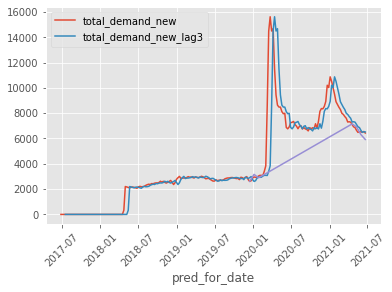

In [734]:
ax = df.loc[df.zone_id == 972][['total_demand_new', 'total_demand_new_lag3']].plot()

f4.loc[f4.zone_id == 972].pred.plot(ax=ax)

ax.xaxis.set_tick_params(rotation=45)

In [509]:
f1.loc[f1.zone_id == 787][['date', 'total_demand_new', 'pred', 'total_demand_new_lag3']]

,date,total_demand_new,pred,total_demand_new_lag3
pred_for_date,,,,
2021-06-21,2021-06-21,3004.375691,8.526171e+02,3265.079548
2021-05-31,2021-05-31,3265.079548,-1.013012e+02,3259.695788
2021-05-10,2021-05-10,3259.695788,-3.164240e+03,3560.283871
2021-04-19,2021-04-19,3560.283871,1.960622e+06,3637.874023
2020-01-27,2020-01-27,1461.759721,1.494049e+03,1335.743291
2020-01-06,2020-01-06,1335.743291,1.524767e+03,1263.330682
2019-12-16,2019-12-16,1263.330682,1.314865e+03,1253.453050


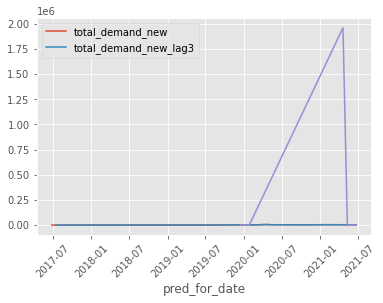

In [510]:
ax = df.loc[df.zone_id == 787][['total_demand_new', 'total_demand_new_lag3']].plot()

f1.loc[f1.zone_id == 787].pred.plot(ax=ax)

ax.xaxis.set_tick_params(rotation=45)

/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


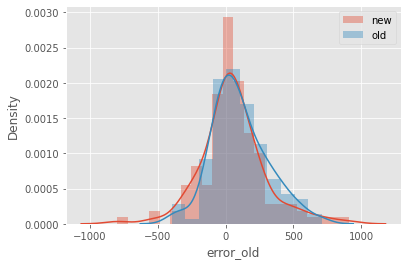

In [737]:
ax = sns.distplot(f4.error_new, label='new')
sns.distplot(f4.error_old, label='old')

ax.legend(loc='best')